In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.metrics import Recall,Precision,AUC
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix

In [62]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Model,Sequential
from tensorflow import keras
from keras.layers import Input,DepthwiseConv2D,ReLU, Add
from keras import layers, models
from keras.applications import VGG19
from keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)

def vgg19():
    # Load MobileNetV2 pre-trained on ImageNet
    input_shape=(128,128, 3)
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    for layer in base_model.layers:
      layer.trainable=False
    model=Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(512,"relu",kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dense(1,activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              metrics=['accuracy',Precision(),Recall(),AUC()],
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

Found 92 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_28 (Ba  (None, 25088)             100352    
 tchNormalization)                                               
                                                                 
 dense_28 (Dense)            (None, 512)               12845568  
         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


test loss: 0.13904
test acc: 98.00
1/1 [==============================] - 36s 36s/step


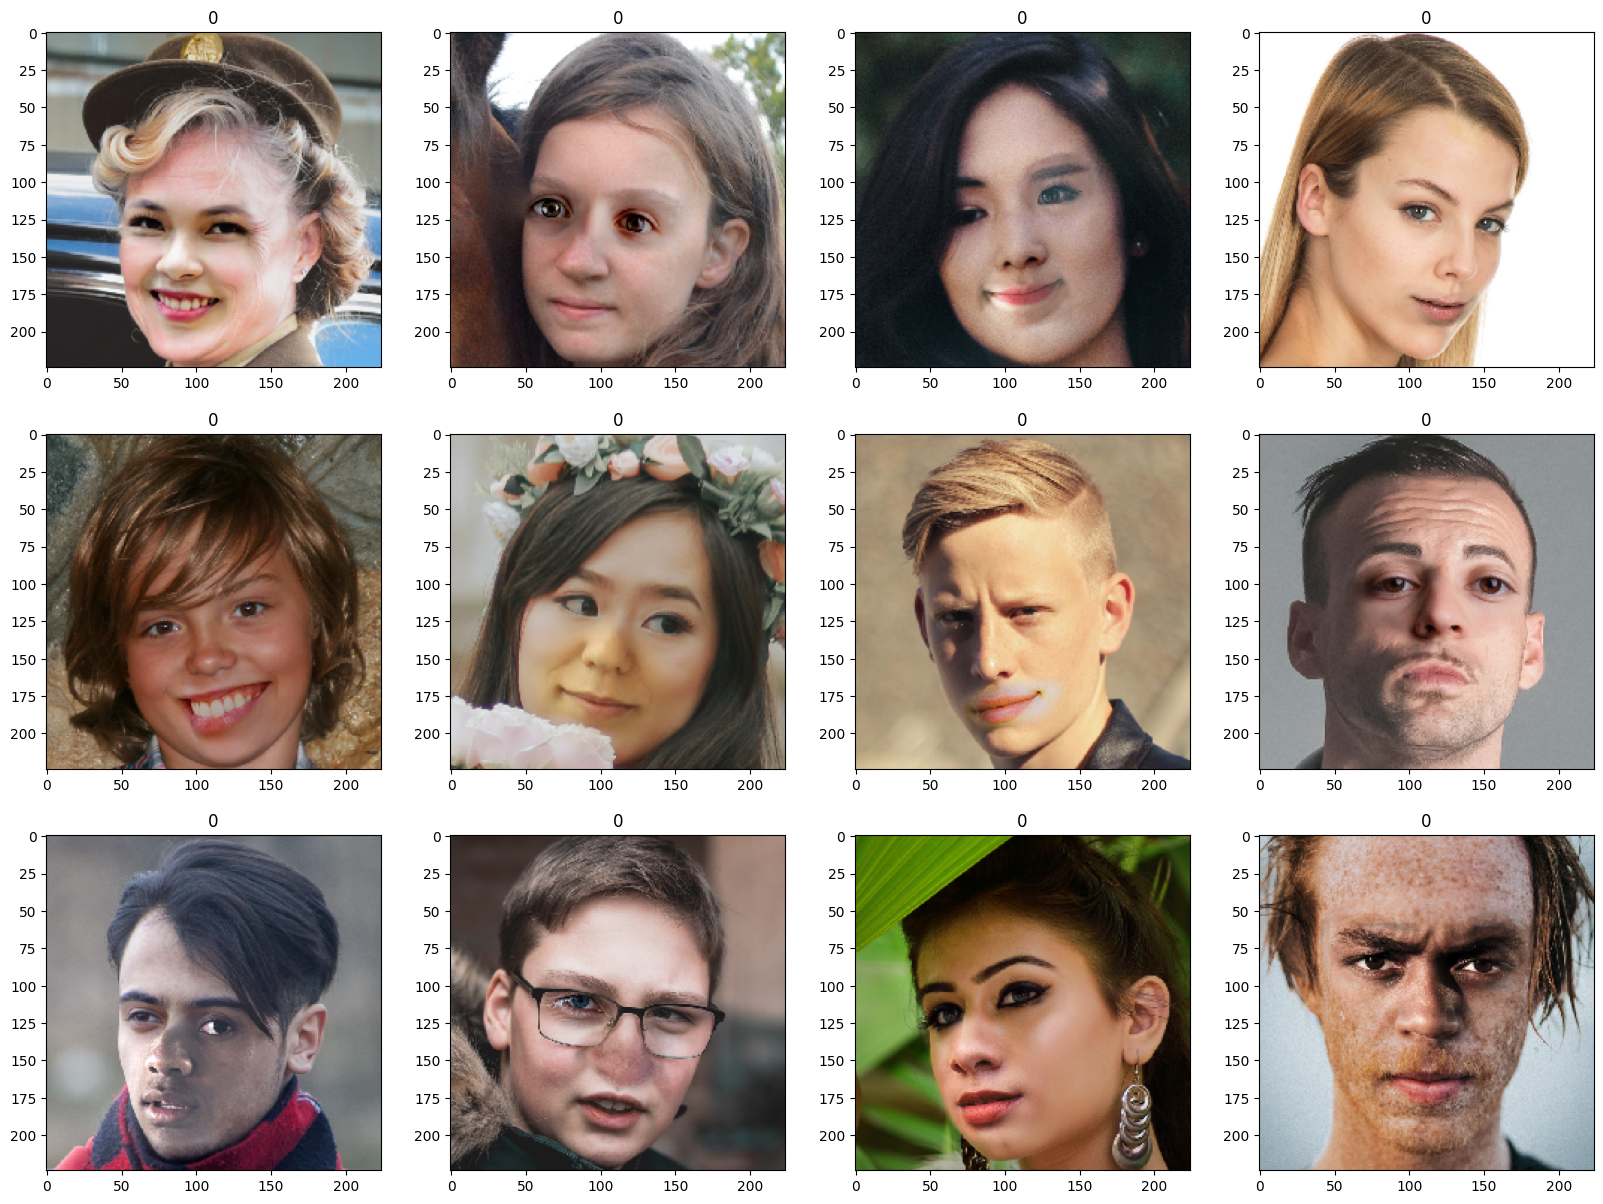

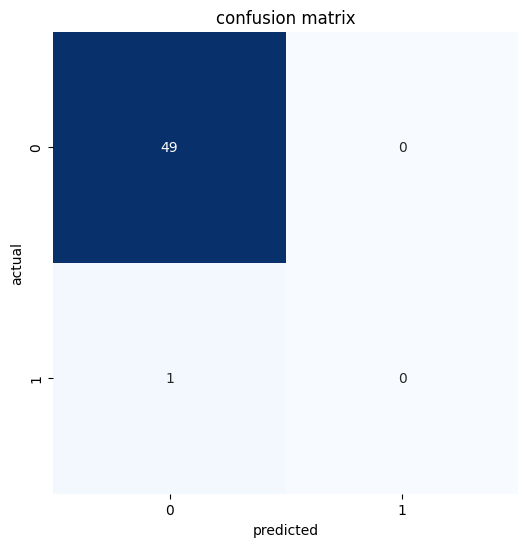

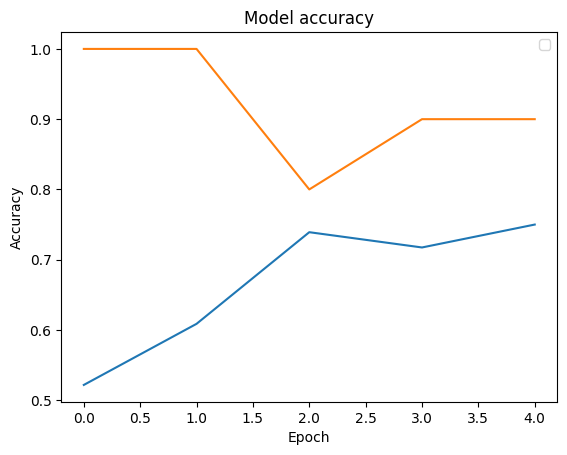

In [63]:
import zipfile
import os
import datetime

zip_path = '/content/sample_data/celeb-df.zip'
extract_path = '/content/simple_data'  # Change this to the desired extraction path

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

image_dir=Path(extract_path)
filepaths= list(image_dir.glob(r'**/*.jpg'))
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df=pd.concat([filepaths,labels],axis=1)

train_df,test_df=train_test_split(image_df,train_size=0.7,shuffle=True,random_state=1)
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False,
    seed= 42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False
)

plt.figure(figsize=(20, 20))
for images, labels in train_images:
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(int(labels[i]))
        plt.axis("on")
    break

# Create the model
model =vgg19()
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Print model summary
model.summary()
history=model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,

    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=4,
            restore_best_weights=True
        ),
         tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )

    ]
)
model.save_weights('my_model_weights.h5')
model.save('140kdfrf_model.h5')

results=model.evaluate(test_images,verbose=0)
print("test loss: {:.5f}".format(results[0]))
print("test acc: {:.2f}".format(results[1]*100))
predictions=(model.predict(test_images)>=0.5).astype(int)
cm=confusion_matrix(test_images.labels,predictions,labels=[0,1])
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=False)
plt.xticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.yticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc="best")
plt.show()



In [65]:
report = classification_report(test_images.labels,predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        49
           1       0.00      0.00      0.00         1

    accuracy                           0.98        50
   macro avg       0.49      0.50      0.49        50
weighted avg       0.96      0.98      0.97        50



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
